# Introduction
The report contains the basic task for HW9. Two networks, a unidirectional GRU and a bidirectional GRU have been constructed to run with both word embeddings  and subword embeddings created using BERT. 

# The Dataset

The dataset is simple with the list used to initalize it being read from a .pkl file.
The .pkl file is constructed as such
{'train': [{'sentence':"......",'sentiment':[X,X,X]},....],
'test' : [{'sentence':"......",'sentiment':[X,X,X]},....]}

In [ ]:
class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, datalist):
        super(EmbeddingDataset, self).__init__()
        self.datapoints = datalist

    def __len__(self):
        return len(self.datapoints)

    def __getitem__(self,index):
        return self.datapoints[index]['sentence'],self.datapoints[index]['sentiment']

# GRU and BiGRU network

Both the BRU and BiGRU network have been based off the network in DLStudio. There is a nn.GRU block followed by a fully connected layer which takes the output and translates it to a size 3 tensor. There is a final softmax applied to represent probabilities of the three classes positive, neutral and negative. The network also has a init_hidden function that initializes a hidden layer value to pass to the GRU block. The dimensionality is different for unidirectional and bidirectional hidden layers, the first axis is twice the number of layers.

Both GRU networks will take the same input size of 768(the embedding size) and a hidden and output size of 512.

In [ ]:
# Architecture modified from https://engineering.purdue.edu/kak/distDLS/DLStudio-2.4.3_CodeOnly.html
class GRUnet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers,  batch_size, drop_prob=0.2):
        super(GRUnet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers,batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.batch_size = batch_size

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        out = self.softmax(out)
        return out, h

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(  self.num_layers,    self.batch_size,         self.hidden_size   ).zero_()
        return hidden

In [ ]:
# Architecture modified from https://engineering.purdue.edu/kak/distDLS/DLStudio-2.4.3_CodeOnly.html
class BiGRUnet(torch.nn.Module):
            def __init__(self, input_size, hidden_size, output_size, num_layers,  batch_size, drop_prob=0.2):
                super(BiGRUnet, self).__init__()
                self.hidden_size = hidden_size
                self.num_layers = num_layers
                self.gru = nn.GRU(input_size, hidden_size, num_layers,batch_first=True, dropout=drop_prob, bidirectional=True)
                self.fc = nn.Linear(2*hidden_size, output_size)
                self.relu = nn.ReLU()
                self.softmax = nn.Softmax(dim=1)
                self.batch_size = batch_size

            def forward(self, x, h):
                out, h = self.gru(x, h)
                out = self.fc(self.relu(out[:,-1]))
                out = self.softmax(out)
                return out, h

            def init_hidden(self):
                weight = next(self.parameters()).data
                #                                     batch_size
                hidden = weight.new(  2*self.num_layers,    self.batch_size,         self.hidden_size   ).zero_()
                return hidden

# Training Code for GRU and BiGRU

Since the GRU blocks are running on 'batch_first' mode they will accept input tensors in the format [batch_size, sequence_length, embedding_size]. So we will use squeeze on the dataloader which outputs tensors the shape of [batch_size, 1,sequence_length, embedding_size]. It is worth noting the different hidden shapes needed for the two networks is handled by the init_hidden() function. The entire sequence is passed to the GRU at once and the sequence parsing takes place under the hood. 

We use the CrossEntropyLoss() criterion with class weights to account for the imbalanced nature of the datasets. The numbers for the weights were obtained by calculating the inverse of the ratio of the class in the dataset(with some additional tweaking). 

The optimizer is an Adam optimizer with a learning rate of 5e-4 and betas equal to (0.9,0.999)

In [ ]:
# Code modified from https://engineering.purdue.edu/kak/distDLS/DLStudio-2.4.3_CodeOnly.html
def run_code_for_training_GRU(net, train_dataloader,epochs = 5, learning_rate = 1e-3, momentum = 0.5, display_train_loss=False):
    filename_for_out = "performance_numbers_" + str(epochs) + ".txt"
    FILE = open(filename_for_out, 'w')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    class_weights = torch.tensor([4.15,1.87,5.79],dtype=torch.float)
    class_weights = class_weights.to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights,reduction='mean')

    accum_times = []

    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, betas = (0.9,0.999))
    start_time = time.perf_counter()
    training_loss_tally = []
    for epoch in range(epochs):
        print("")
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            sentence,sentiment = data
            
            sentence = torch.squeeze(sentence)
            sentence = sentence.to(device)
            sentiment = sentiment.to(device)
            optimizer.zero_grad()
            hidden = net.init_hidden().to(device)
            
            output, hidden = net(sentence, hidden)
            loss = criterion(output, sentiment)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if i % 200 == 199:
                avg_loss = running_loss / float(200)
                training_loss_tally.append(avg_loss)
                current_time = time.perf_counter()
                time_elapsed = current_time-start_time
                print("[epoch:%d  iter:%4d  elapsed_time:%4d secs]     loss: %.5f" % (epoch+1,i+1, time_elapsed,avg_loss))
                accum_times.append(current_time-start_time)
                FILE.write("%.3f\n" % avg_loss)
                FILE.flush()
                running_loss = 0.0
    print("Total Training Time: {}".format(str(sum(accum_times))))
    print("\nFinished Training\n")

# Base Task Results

## Loss Graphs

### GRU with Word Embeddings

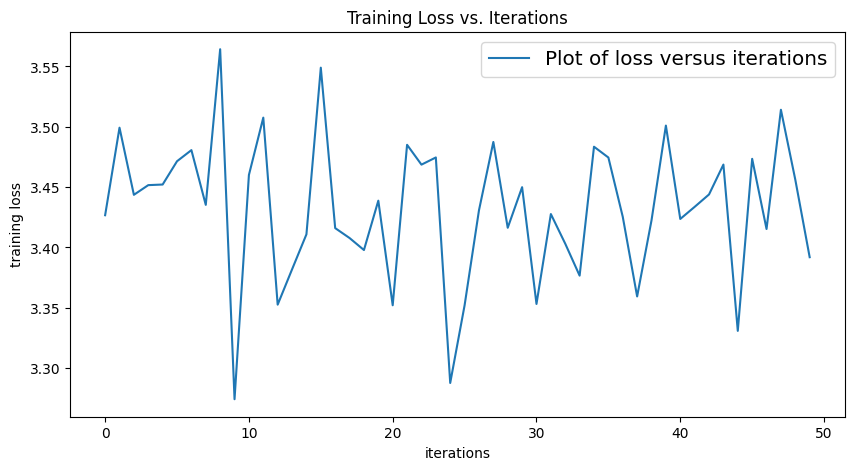

### GRU with Subword Embeddings

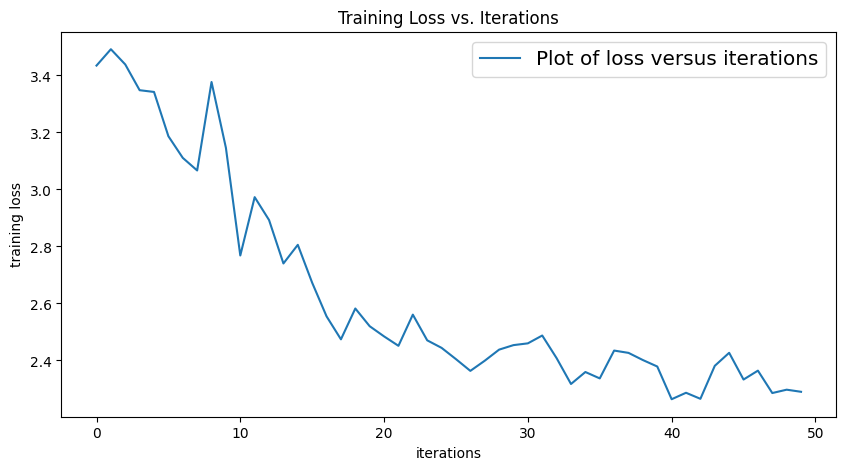

### BiGRU with Word Embeddings

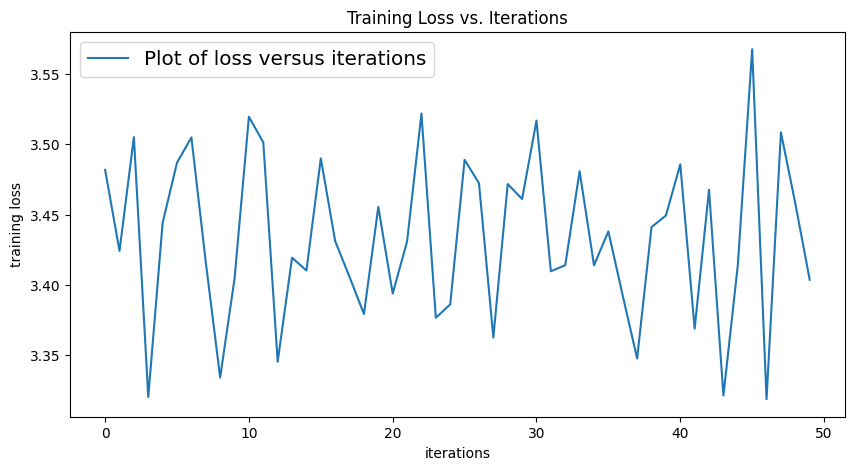

### BiGRU with Subword Embeddings

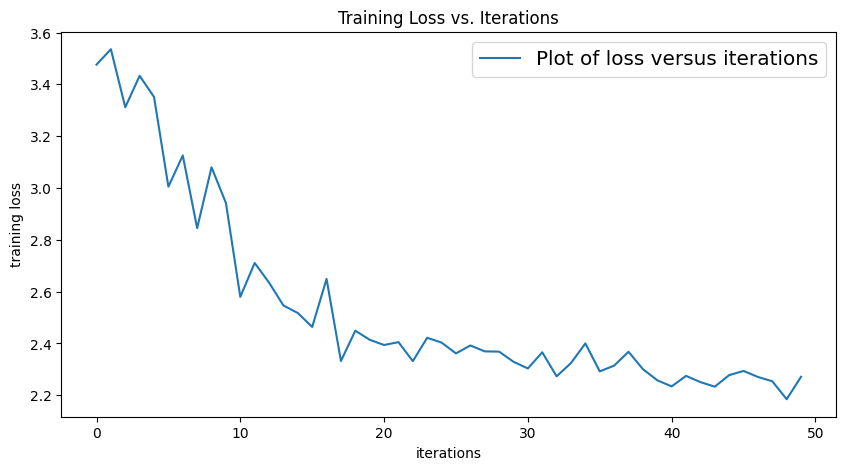

## Confusion Matrix

### GRU with Word Embeddings

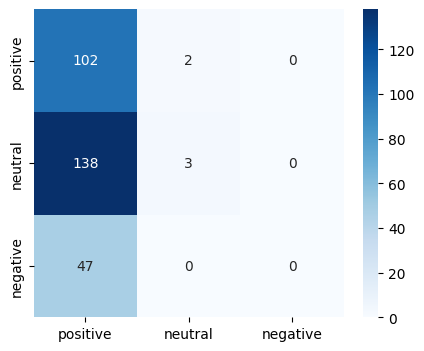

### GRU with Subword Embeddings

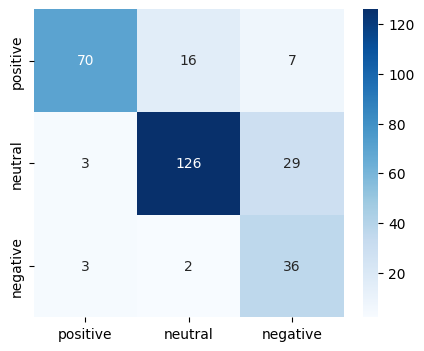

### BiGRU with Word Embeddings

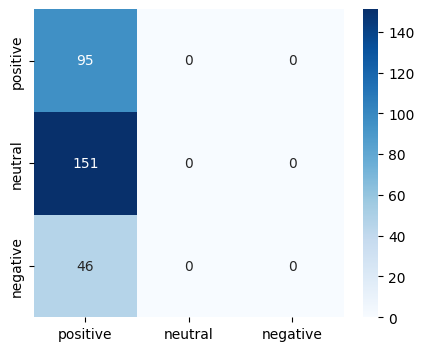

### BiGRU with Subword Embeddings

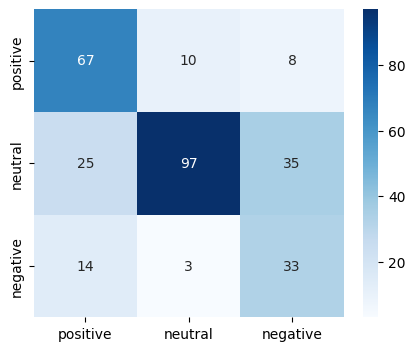

# Results Discussion

Both GRU and BiGRU give good results for the subword embeddings with GRU giving 79% and BiGRU giving 67%. On different runs the BiGRU gave better results. So we can say they are approximately the same and the variations are based on how the dataloader feeds the data and they might be equal over long runs. 

The GRU and BiGRU absoutely fail on the word embeddings. Almost no learning takes place and the models just predict a single class with highest weight to the loss. They both classify all the test data as predominantly one class, the GRU achieves a 36% accuracy and the BiGRU achieves 35% with word embeddings.

The subword tokenizations seem to be far superior to the word tokenization, in the former we see actual learning which means the model can be improved with better data, longer training or better architecture. The later has no learning taking place.

# Extra Credit

The same GRU and BiGRU models were trained on the word2vec embeddings provided on https://engineering.purdue.edu/kak/distDLS/. The function for training is borrowed from https://engineering.purdue.edu/kak/distDLS/DLStudio-2.4.3_CodeOnly.html. The training was performed with batch size of 1 since each tensor is of variable shape.

## Results 

### Loss Graph

#### GRU with 200 reviews

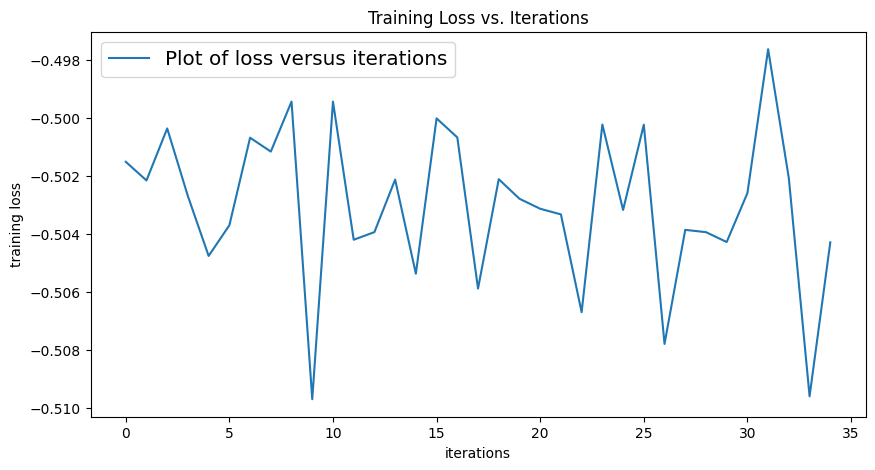

#### BiGRU with 200 reviews

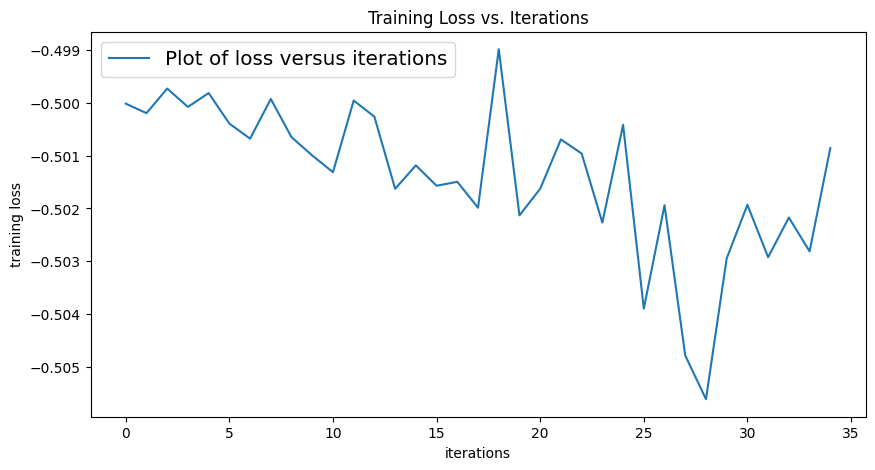

#### GRU with 400 reviews

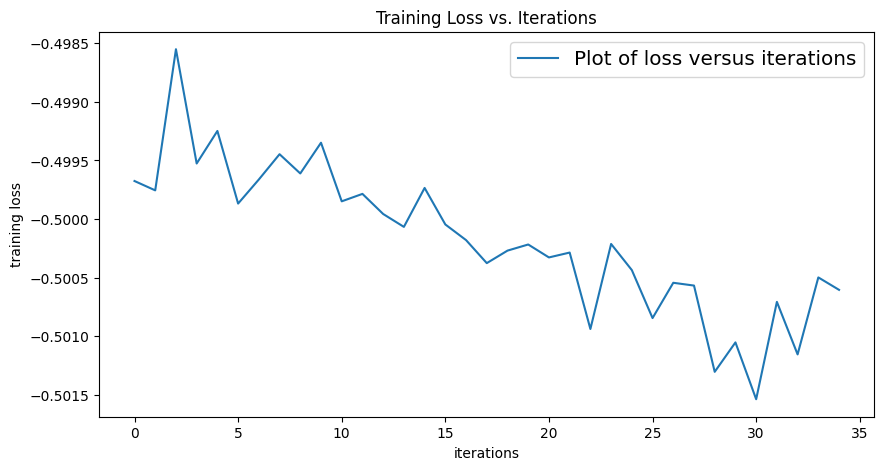

#### BiGRU with 400 reviews

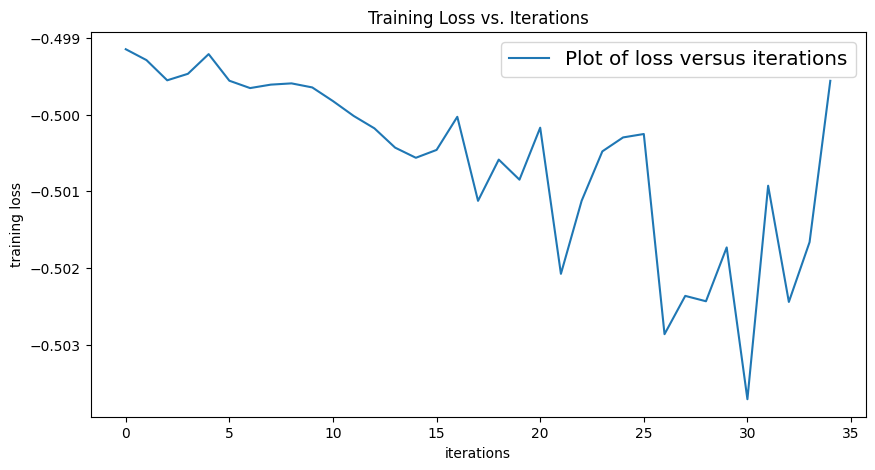

### Confusion Matrices

#### GRU with 200 reviews

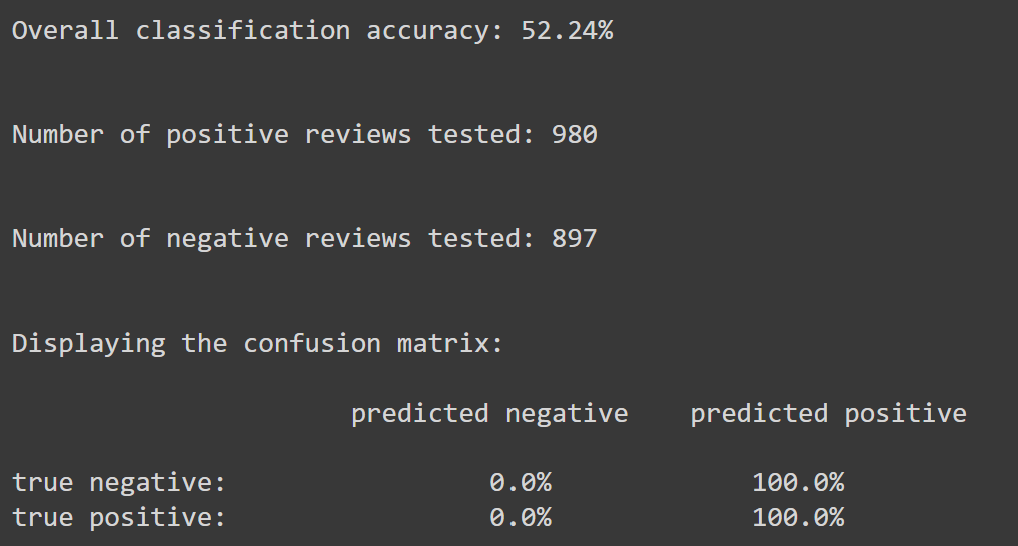

#### BiGRU with 200 reviews

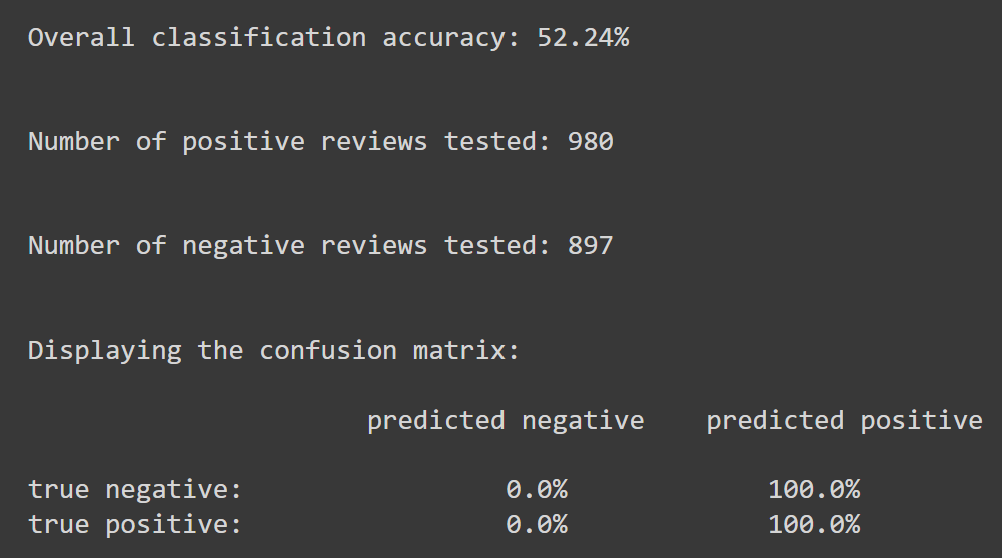

#### GRU with 400 reviews

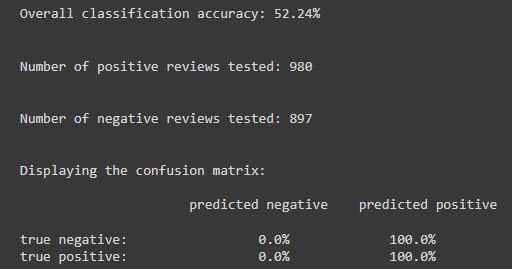

#### BiGRU with 400 reviews

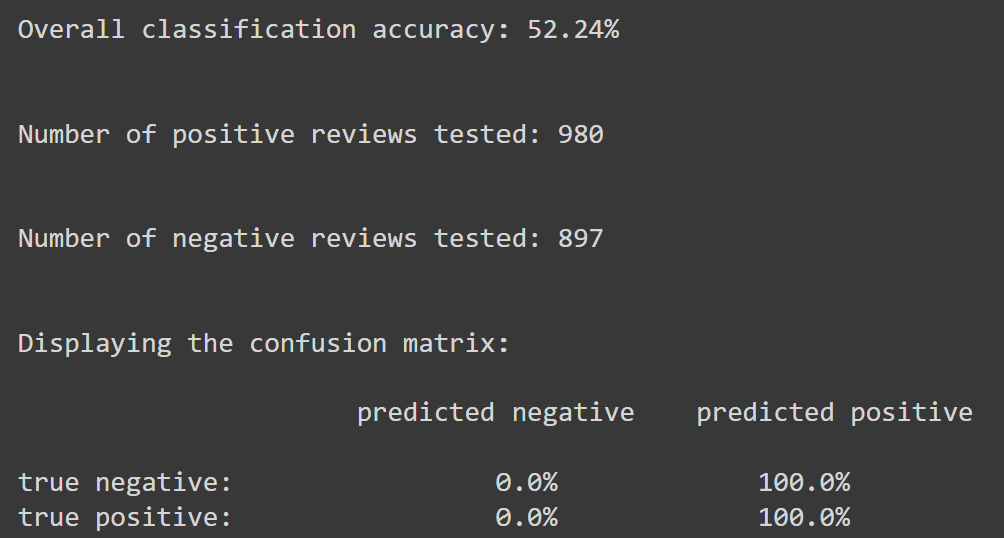

# Code 

In [ ]:
import pickle
import torch
import torch.nn as nn
import random
from torch.utils.data import DataLoader
import time
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
import google.colab.auth
google.colab.auth.authenticate_user()
drive.mount('/content/drive')

class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, datalist):
        super(EmbeddingDataset, self).__init__()
        # with open(file, 'rb') as f:
        self.datapoints = datalist

    def __len__(self):
        return len(self.datapoints)

    def __getitem__(self,index):
        return self.datapoints[index]['sentence'],self.datapoints[index]['sentiment']

with open('/content/drive/My Drive/ece60146/HW9/bert_embedding_classes.pkl', 'rb') as f:
    data = pickle.load(f)
    bert_train_dataset = EmbeddingDataset(data['train'])
    bert_test_dataset = EmbeddingDataset(data['test'])

with open('/content/drive/My Drive/ece60146/HW9/custom_embedding_classes.pkl', 'rb') as f:
    data = pickle.load(f)
    manual_train_dataset = EmbeddingDataset(data['train'])
    manual_test_dataset = EmbeddingDataset(data['test'])


bert_train_dataloader = DataLoader(bert_train_dataset, batch_size = 4,shuffle = True , drop_last = True)
bert_test_dataloader = DataLoader(bert_test_dataset, batch_size = 4,shuffle = True , drop_last = True)
manual_train_dataloader = DataLoader(manual_train_dataset, batch_size = 4,shuffle = True , drop_last = True)
manual_test_dataloader = DataLoader(manual_test_dataset, batch_size = 4,shuffle = True , drop_last = True)

# for data in dataloader:
#     sente,senti = data
#     # print(data)
#     print(sente)
#     print(senti)
#     break
# print(len(dataloader))

# Architecture modified from https://engineering.purdue.edu/kak/distDLS/DLStudio-2.4.3_CodeOnly.html
class GRUnet(torch.nn.Module):
            def __init__(self, input_size, hidden_size, output_size, num_layers,  batch_size, drop_prob=0.2):
                super(GRUnet, self).__init__()
                self.hidden_size = hidden_size
                self.num_layers = num_layers
                self.gru = nn.GRU(input_size, hidden_size, num_layers,batch_first=True, dropout=drop_prob)
                self.fc = nn.Linear(hidden_size, output_size)
                self.relu = nn.ReLU()
                self.softmax = nn.Softmax(dim=1)
                self.batch_size = batch_size

            def forward(self, x, h):
                out, h = self.gru(x, h)
                out = self.fc(self.relu(out[:,-1]))
                out = self.softmax(out)
                return out, h

            def init_hidden(self):
                weight = next(self.parameters()).data
                #                                     batch_size
                hidden = weight.new(  self.num_layers,    self.batch_size,         self.hidden_size   ).zero_()
                return hidden

# Architecture modified from https://engineering.purdue.edu/kak/distDLS/DLStudio-2.4.3_CodeOnly.html
class BiGRUnet(torch.nn.Module):
            def __init__(self, input_size, hidden_size, output_size, num_layers,  batch_size, drop_prob=0.2):
                super(BiGRUnet, self).__init__()
                self.hidden_size = hidden_size
                self.num_layers = num_layers
                self.gru = nn.GRU(input_size, hidden_size, num_layers,batch_first=True, dropout=drop_prob, bidirectional=True)
                self.fc = nn.Linear(2*hidden_size, output_size)
                self.relu = nn.ReLU()
                self.softmax = nn.Softmax(dim=1)
                self.batch_size = batch_size

            def forward(self, x, h):
                out, h = self.gru(x, h)
                out = self.fc(self.relu(out[:,-1]))
                out = self.softmax(out)
                return out, h

            def init_hidden(self):
                weight = next(self.parameters()).data
                #                                     batch_size
                hidden = weight.new(  2*self.num_layers,    self.batch_size,         self.hidden_size   ).zero_()
                return hidden

gru_network_bert = GRUnet(input_size = 768, hidden_size = 512,output_size = 3, num_layers = 2, batch_size = 4)
bi_gru_network_bert = BiGRUnet(input_size = 768, hidden_size = 512,output_size = 3, num_layers = 2, batch_size = 4)

gru_network_manual = GRUnet(input_size = 768, hidden_size = 512,output_size = 3, num_layers = 2, batch_size = 4)
bi_gru_network_manual = BiGRUnet(input_size = 768, hidden_size = 512,output_size = 3, num_layers = 2, batch_size = 4)

# Code modified from https://engineering.purdue.edu/kak/distDLS/DLStudio-2.4.3_CodeOnly.html
def run_code_for_training_GRU(net, train_dataloader,epochs = 5, learning_rate = 1e-3, momentum = 0.5, display_train_loss=False):
    filename_for_out = "performance_numbers_" + str(epochs) + ".txt"
    FILE = open(filename_for_out, 'w')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    class_weights = torch.tensor([4.15,1.87,5.79],dtype=torch.float)
    class_weights = class_weights.to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights,reduction='mean')

    accum_times = []
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, betas = (0.9,0.999))
    start_time = time.perf_counter()
    training_loss_tally = []
    for epoch in range(epochs):
        print("")
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            sentence,sentiment = data
            sentence = torch.squeeze(sentence)
            sentence = sentence.to(device)
            sentiment = sentiment.to(device)

            optimizer.zero_grad()
            hidden = net.init_hidden().to(device)

            output, hidden = net(sentence, hidden)
            loss = criterion(output, sentiment)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            if i % 200 == 199:
                avg_loss = running_loss / float(200)
                training_loss_tally.append(avg_loss)
                current_time = time.perf_counter()
                time_elapsed = current_time-start_time
                print("[epoch:%d  iter:%4d  elapsed_time:%4d secs]     loss: %.5f" % (epoch+1,i+1, time_elapsed,avg_loss))
                accum_times.append(current_time-start_time)
                FILE.write("%.3f\n" % avg_loss)
                FILE.flush()
                running_loss = 0.0
    print("Total Training Time: {}".format(str(sum(accum_times))))
    print("\nFinished Training\n")

    if display_train_loss:
        plt.figure(figsize=(10,5))
        plt.title("Training Loss vs. Iterations")
        plt.plot(training_loss_tally)
        plt.xlabel("iterations")
        plt.ylabel("training loss")
        plt.legend(["Plot of loss versus iterations"], fontsize="x-large")
        plt.show()

# Architecture modified from https://engineering.purdue.edu/kak/distDLS/DLStudio-2.4.3_CodeOnly.html
def run_code_for_testing_GRU(net, dataloader, bi=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    confusion_matrix = torch.zeros(3, 3)
    correct = 0
    total = 0
    class_correct = [0] * 3
    class_total = [0] * 3
    D = 2 if bi else 1
    with torch.no_grad():
        for i,data in enumerate(dataloader):

            weight = next(net.parameters()).data
            hidden = weight.new(  D*net.num_layers,    1,         net.hidden_size   ).zero_()
            sentence,sentiment = data
            sentence = sentence[0]
            sentence = sentence.to(device)
            sentiment = sentiment.to(device)
            outputs, hidden = net(sentence,hidden)
            predicted = outputs
            for sentiment,prediction in zip(sentiment,predicted):
                    confusion_matrix[torch.argmax(sentiment)][torch.argmax(prediction)] += 1
                    correct += 1 if torch.argmax(sentiment) == torch.argmax(prediction) else 0
                    total += 1

            if (i%1000 == 999):
                print(i)
    print(confusion_matrix)
    print('Accuracy of the network: %d %%' % (100 * correct / total))
    cm_heatmap = pd.DataFrame(confusion_matrix.numpy(), index = ['positive','neutral','negative'],
                  columns = ['positive','neutral','negative'])
    plt.figure(figsize = (5,4))
    sn.heatmap(cm_heatmap, annot=True, cmap='Blues', fmt='g')
    return confusion_matrix

run_code_for_training_GRU(gru_network_bert, bert_train_dataloader,epochs = 10, learning_rate = 5e-4, momentum = 0.5, display_train_loss=True)
cm = run_code_for_testing_GRU(gru_network_bert, bert_test_dataloader, bi = False)

run_code_for_training_GRU(gru_network_manual, manual_train_dataloader,epochs = 10, learning_rate = 5e-4, momentum = 0.5, display_train_loss=True)
cm = run_code_for_testing_GRU(gru_network_manual, manual_test_dataloader, bi = False)

run_code_for_training_GRU(bi_gru_network_bert, bert_train_dataloader,epochs = 10, learning_rate = 5e-4, momentum = 0.5, display_train_loss=True)
cm = run_code_for_testing_GRU(bi_gru_network_bert, bert_test_dataloader, bi = True)

run_code_for_training_GRU(bi_gru_network_manual, manual_train_dataloader,epochs = 10, learning_rate = 5e-4, momentum = 0.5, display_train_loss=True)
cm = run_code_for_testing_GRU(bi_gru_network_manual, manual_test_dataloader, bi = True)

torch.save(bi_gru_network_bert.state_dict(), '/content/drive/My Drive/ece60146/HW9/models/bi_gru_bert.pt')
torch.save(bi_gru_network_manual.state_dict(), '/content/drive/My Drive/ece60146/HW9/models/bi_gru_manual.pt')
torch.save(gru_network_bert.state_dict(), '/content/drive/My Drive/ece60146/HW9/models/gru_bert.pt')
torch.save(gru_network_manual.state_dict(), '/content/drive/My Drive/ece60146/HW9/models/gru_manual.pt')